## Project for rmrb - Part #[3]

### Corpus final filtering by Word2Vec and Doc2Vec

In [2]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [3]:
import dask
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import jieba
import re
import string
from zhon.hanzi import punctuation, stops, non_stops
import gensim
from gensim.models.word2vec import Word2Vec, LineSentence
import linecache
import timeit
import warnings
import zipfile
import os
import sys
warnings.filterwarnings('ignore')

## raw corpus loading

In [3]:
news_df_sort=pd.read_csv('rmrb_tokened.csv')

In [4]:
news_df_sort=news_df_sort.drop(['Unnamed: 0'], axis=1)

In [5]:
corpus=news_df_sort.copy()

In [6]:
# transfer string back to list

tokenized_sent_str=news_df_sort['tokenized_sent'].values

In [7]:
token_sent_clean=[]
for doc in tokenized_sent_str:
    #print(doc)
    token_sent_clean.append([[y.strip().strip(string.punctuation) for y in x.split(',') if len(y)>0] 
                             for x in doc.lstrip('[').rstrip(']').split(']') if len(x)>0])

In [8]:
corpus=corpus.drop(['tokenized_sent'],axis=1)
corpus.insert(9, 'tokenized_sent',token_sent_clean,True)

In [9]:
tokenized_para_str=news_df_sort['token_para'].values

In [10]:
token_para_clean=[]
for doc in tokenized_para_str:
    #print(doc)
    token_para_clean.append([x.strip().strip("'") 
                             for x in doc.lstrip('[').rstrip(']').split(',') if len(x)>0])

In [11]:
corpus=corpus.drop(['token_para'],axis=1)
corpus.insert(9, 'token_para',token_para_clean,True)

In [12]:
corpus.head()

,year,month,date,issue,column,title,author,text,tokenized_sent,token_para
0,1960,1,1960-01-01,1,社论,展望六十年代,NaN,的最后一年，1959年，过去了；六十年代（1960—1969）的第一年，1960年，开始了。...,"[[最后, 一年, 1959, 过去, 六十年代, 19601969, 第一年, 1960,...","[最后 一年 1959 过去 六十年代 19601969 第一年 1960 开始, 十年 不..."
1,1960,1,1960-01-01,2,NaN,克拉玛依建设者冒雪夺油,NaN,在白雪茫茫的克拉玛依油区，气温已经下降到零下三十多度。但是，不论在井架下、油井旁，或是在大...,"[[白雪, 茫茫, 克拉玛依, 油区, 气温, 已经, 下降, 零下, 三十多], [但是,...","[白雪 茫茫 克拉玛依 油区 气温 已经 下降 零下 三十多, 但是 不论 井架 油井 或是..."
2,1960,1,1960-01-01,2,NaN,鞍钢健儿举行技术大检阅,NaN,英雄立大志 定叫新年胜旧年钢铁、煤炭、机械、石油、纺织、基建、交通职工越战越强据新华社鞍山3...,"[[英雄, 大志, 新年, 旧年], [钢铁, 煤炭, 机械, 石油, 纺织, 基建, 交通...","[英雄 大志 新年 旧年, 钢铁 煤炭 机械 石油 纺织 基建 交通 职工 越战 越强, 新..."
3,1960,1,1960-01-01,2,NaN,红旗采煤队新年红旗飘,NaN,29日深夜零点，当乌亮的煤块从井下随着皮带运输机滚滚流向地面时，工人们发出了一片喝采声。太...,"[[29, 深夜, 零点, 乌亮, 煤块, 井下, 随着, 皮带, 运输机, 滚滚, 流向,...",[29 深夜 零点 乌亮 煤块 井下 随着 皮带 运输机 滚滚 流向 地面 工人 发出 一片...
4,1960,1,1960-01-01,2,NaN,三门峡彻夜灯火辉煌 叫大坝今年全部拦洪,NaN,寒夜降临三门峡。但是，在三门峡工地，黑夜仍同白昼一样，到处是忙碌着的人群。聚光灯和电焊火花...,"[[寒夜, 降临, 三门峡], [但是, 三门峡, 工地, 黑夜, 仍同, 白昼, 一样, ...","[寒夜 降临 三门峡, 但是 三门峡 工地 黑夜 仍同 白昼 一样 到处 忙碌 人群, 聚光..."


In [13]:
# get the time from 1965 to 2002

year1=[int(x) for x in range(1965,2003)]

sample_all=corpus[:0]
for year in year1:
    sample_all=sample_all.append(corpus[corpus['year']==year])

In [14]:
sample_all

,year,month,date,issue,column,title,author,text,tokenized_sent,token_para
64321,1965,1,1965-01-01,1,NaN,刘少奇主席召集最高国务会议,NaN,刘主席就当前国际国内形势和工作中的一些重要问题作了讲话会议对周恩来总理在人大会议上作的“政府...,"[[主席, 当前, 国际, 国内形势, 工作, 一些, 重要, 问题, 讲话], [会议, ...","[主席 当前 国际 国内形势 工作 一些 重要 问题 讲话, 会议 周恩来 总理 人大 会议..."
64322,1965,1,1965-01-01,1,NaN,毛主席刘主席等领导人同五万军民联欢迎接新年,NaN,首都举行盛大的拥军优属、拥政爱民新年联欢晚会人大代表政协委员也同军民联欢，全场洋溢着团结欢乐...,"[[首都, 举行, 盛大, 拥军优属, 拥政爱民, 新年, 联欢晚会], [人大代表, 政协...","[首都 举行 盛大 拥军优属 拥政爱民 新年 联欢晚会, 人大代表 政协委员 军民联欢 全场..."
64323,1965,1,1965-01-01,2,NaN,政协四届首次会议继续举行大会,NaN,政协第三届全国委员会副主席、西藏自治区筹备委员会副主任委员帕巴拉·格列朗杰用大量事实，揭发和...,"[[政协, 第三届, 全国, 委员会, 主席, 西藏自治区筹备委员会, 主任委员, 帕巴拉,...",[政协 第三届 全国 委员会 主席 西藏自治区筹备委员会 主任委员 帕巴拉 格列朗 杰用 大...
64324,1965,1,1965-01-01,2,NaN,三届人大首次会议继续举行大会,NaN,四十位代表作了发言或书面发言同意政府工作报告西藏代表阿沛·阿旺晋美揭露了达赖集团的叛国罪行，...,"[[四十位, 代表作, 发言, 书面发言, 同意, 政府, 工作, 报告], [西藏, 代表...","[四十位 代表作 发言 书面发言 同意 政府 工作 报告, 西藏 代表 阿沛 阿旺晋美 揭露..."
64325,1965,1,1965-01-01,2,NaN,三届人大首次会议 举行主席团扩大会议讨论国家领导人等候选人名单问题 三届人大首次会议的各代表...,NaN,第三届全国人民代表大会第一次会议，三十日举行主席团扩大会议，讨论了即将在第三届全国人民代表...,"[[第三届, 全国人民代表大会, 第一次, 会议, 三十日, 举行, 主席团, 扩大, 会议...",[第三届 全国人民代表大会 第一次 会议 三十日 举行 主席团 扩大 会议 讨论 即将 第三...
...,...,...,...,...,...,...,...,...,...,...
561532,2002,12,2002-12-31,4_要闻,认真贯彻中办通知精神做好人民日报发行工作,宿迁全面完成发行计划,龚永泉顾兆农,本报南京12月30日电记者龚永泉、顾兆农报道：12月23日，江苏省宿迁市率先在全省全面完成2...,"[[本报, 南京, 12, 30, 日电, 记者, 龚永泉, 顾兆农, 报道, 12, 23...",[本报 南京 12 30 日电 记者 龚永泉 顾兆农 报道 12 23 江苏省 宿迁市 率先...
561533,2002,12,2002-12-31,4_要闻,NaN,为解决制造假账、违规开支、私设小金库、乱集资摊派等财政管理中长期存在的问题——安顺：会计集中...,孙海涛,贵州省安顺市去年7月在全省率先改革旧的财政管理体制，在全市实行市、县、乡3级会计集中核算。该...,"[[贵州省, 安顺市, 去年, 全省, 率先, 改革, 财政管理, 体制, 全市, 实行, ...",[贵州省 安顺市 去年 全省 率先 改革 财政管理 体制 全市 实行 市县 会计 集中 核算...
561534,2002,12,2002-12-31,4_要闻,NaN,陈良宇会见德国总理,周解蓉吴宇,上海市市长陈良宇30日晚在这里会见了德意志联邦共和国总理格哈德·施罗德。施罗德一行是于30日...,"[[上海市, 市长, 陈良宇, 30, 日晚, 这里, 会见, 德意志联邦共和国, 总理, ...","[上海市 市长 陈良宇 30 日晚 这里 会见 德意志联邦共和国 总理 格哈德 施罗德, 施..."
561535,2002,12,2002-12-31,4_要闻,扶贫济困送温暖,山东向灾民发放救灾款,何勇,山东省大力开展农村救灾工作，到目前，全省共投放救灾款1.8亿元，救济灾民600多万人。今年以...,"[[山东省, 大力开展, 农村, 救灾, 工作, 目前, 全省, 投放, 救灾款], [亿元...","[山东省 大力开展 农村 救灾 工作 目前 全省 投放 救灾款, 亿元 救济灾民 600 多..."


## add `date_title` column

In [145]:
## as some news have same titles, add the date_title column

date_col=sample_all['date'].values
title_col=sample_all['title'].values

print(len(date_col)==len(title_col))

True


In [152]:
date_title=[]

for i in range(len(date_col)):
    date_title.append(str(date_col[i])+str(title_col[i]))

In [154]:
len(date_title)

497216

In [155]:
sample_all2=sample_all.copy()

In [156]:
sample_all2.insert(5, 'date_title',date_title, True)

In [157]:
sample_all2.head()

,year,month,date,issue,column,date_title,title,author,text,tokenized_sent,token_para
64321,1965,1,1965-01-01,1,NaN,1965-01-01刘少奇主席召集最高国务会议,刘少奇主席召集最高国务会议,NaN,刘主席就当前国际国内形势和工作中的一些重要问题作了讲话会议对周恩来总理在人大会议上作的“政府...,"[[主席, 当前, 国际, 国内形势, 工作, 一些, 重要, 问题, 讲话], [会议, ...","[主席 当前 国际 国内形势 工作 一些 重要 问题 讲话, 会议 周恩来 总理 人大 会议..."
64322,1965,1,1965-01-01,1,NaN,1965-01-01毛主席刘主席等领导人同五万军民联欢迎接新年,毛主席刘主席等领导人同五万军民联欢迎接新年,NaN,首都举行盛大的拥军优属、拥政爱民新年联欢晚会人大代表政协委员也同军民联欢，全场洋溢着团结欢乐...,"[[首都, 举行, 盛大, 拥军优属, 拥政爱民, 新年, 联欢晚会], [人大代表, 政协...","[首都 举行 盛大 拥军优属 拥政爱民 新年 联欢晚会, 人大代表 政协委员 军民联欢 全场..."
64323,1965,1,1965-01-01,2,NaN,1965-01-01政协四届首次会议继续举行大会,政协四届首次会议继续举行大会,NaN,政协第三届全国委员会副主席、西藏自治区筹备委员会副主任委员帕巴拉·格列朗杰用大量事实，揭发和...,"[[政协, 第三届, 全国, 委员会, 主席, 西藏自治区筹备委员会, 主任委员, 帕巴拉,...",[政协 第三届 全国 委员会 主席 西藏自治区筹备委员会 主任委员 帕巴拉 格列朗 杰用 大...
64324,1965,1,1965-01-01,2,NaN,1965-01-01三届人大首次会议继续举行大会,三届人大首次会议继续举行大会,NaN,四十位代表作了发言或书面发言同意政府工作报告西藏代表阿沛·阿旺晋美揭露了达赖集团的叛国罪行，...,"[[四十位, 代表作, 发言, 书面发言, 同意, 政府, 工作, 报告], [西藏, 代表...","[四十位 代表作 发言 书面发言 同意 政府 工作 报告, 西藏 代表 阿沛 阿旺晋美 揭露..."
64325,1965,1,1965-01-01,2,NaN,1965-01-01三届人大首次会议 举行主席团扩大会议讨论国家领导人等候选人名单问题 三届...,三届人大首次会议 举行主席团扩大会议讨论国家领导人等候选人名单问题 三届人大首次会议的各代表...,NaN,第三届全国人民代表大会第一次会议，三十日举行主席团扩大会议，讨论了即将在第三届全国人民代表...,"[[第三届, 全国人民代表大会, 第一次, 会议, 三十日, 举行, 主席团, 扩大, 会议...",[第三届 全国人民代表大会 第一次 会议 三十日 举行 主席团 扩大 会议 讨论 即将 第三...


In [178]:
len(sample_all2)

497216

## train D2V

In [179]:
samplef=sample_all2[::]

In [180]:
len(samplef)

497216

In [181]:
%%time

taggedDocs = []
for index, row in samplef.iterrows():
    docKeywords=[]
    #Just doing a simple keyword assignment
    docKeywords.append(row['date_title']) # unique
    #break
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = [y for x in row['tokenized_sent'] for y in x], tags = docKeywords))
samplef['tagged'] = taggedDocs

CPU times: user 1min 24s, sys: 36.8 s, total: 2min
Wall time: 2min 37s


In [182]:
%%time

start=timeit.default_timer()

rmD2V = gensim.models.doc2vec.Doc2Vec(samplef['tagged'], size = 100, seed=10, workers=16) #Limiting to 100 dimensions

CPU times: user 34min 16s, sys: 3min 41s, total: 37min 57s
Wall time: 17min 50s


In [189]:
rmD2V.docvecs[19]

array([ 0.1390343 , -0.04184093,  0.20951532,  0.08464912, -0.02633805,
       -0.3240081 , -0.08124724, -0.18342079,  0.18068203,  0.01235944,
        0.21951292,  0.04588672,  0.4114881 , -0.38541275,  0.4054298 ,
       -0.1226418 , -0.00150532,  0.0074193 ,  0.12879644,  0.29127347,
       -0.09779221, -0.1276845 ,  0.15429698,  0.3276099 ,  0.07633323,
       -0.11210741,  0.08943482, -0.15572542, -0.14702825,  0.05651556,
        0.15699483, -0.20961007,  0.02354704,  0.24540584, -0.19799396,
        0.10389581,  0.12611862,  0.13575055,  0.2294488 ,  0.07824612,
       -0.15885654,  0.07462155,  0.13403511,  0.24623802, -0.21551512,
        0.10353684,  0.11034467,  0.04615293, -0.09779307,  0.04260863,
        0.13664238,  0.13452247,  0.05553785, -0.3185732 ,  0.0717543 ,
        0.23060913, -0.42409918, -0.13239972, -0.17354128,  0.00685339,
        0.11220478, -0.07598538,  0.00786897, -0.09047474, -0.10854724,
       -0.08250108,  0.160467  ,  0.25674373, -0.05683688, -0.10

In [190]:
rmD2V['经济']

array([-0.2886183 ,  0.82047886,  1.5868014 ,  0.9601841 ,  0.68216187,
        1.3617811 ,  3.1735983 , -0.8263085 ,  0.27197364,  1.0266342 ,
       -0.3462706 , -0.9655181 , -2.8298173 ,  0.90870476,  0.99788415,
       -1.1183252 ,  1.8899156 ,  0.92084295,  0.9723655 , -2.9304955 ,
        1.7666119 ,  0.47797465, -0.6381282 ,  0.7529383 , -1.295348  ,
       -4.1088753 ,  0.61286974,  0.7788254 , -1.8349595 , -0.6028864 ,
        0.07394097,  0.94317484, -0.5407687 ,  0.16959631, -1.5808766 ,
        1.1400219 , -0.0648832 , -2.1679869 , -0.3616697 , -0.7454695 ,
        0.4145047 , -0.14465374,  0.9014171 ,  3.1625247 , -3.0370965 ,
       -0.5514436 , -0.51505303,  1.9184579 , -3.2404754 , -2.29703   ,
       -0.04783804,  0.35031527,  2.8489053 ,  1.7328421 , -1.284171  ,
        0.9532832 , -1.3551726 , -0.09934222,  0.07061705,  1.6481503 ,
        0.4637063 ,  2.4076352 , -0.6880851 , -0.9293533 , -3.218049  ,
        2.6491942 ,  1.3527428 ,  2.0499802 ,  1.4535805 ,  3.07

In [191]:
rmD2V.save('rmD2V')

In [192]:
rmD2V.docvecs.most_similar([rmD2V['经济']], topn=10)

[('1995-11-20在亚太经合组织领导人非正式会议上江泽民主席发表讲话', 0.42300668358802795),
 ('1973-05-16发展农业的根本问题在路线', 0.4209457337856293),
 ('1985-01-16赵紫阳视察上海时发表重要意见 从最大经济中心出发改造振兴上海', 0.41295674443244934),
 ('1974-03-30在尼雷尔总统举行的宴会上 尼雷尔总统的讲话', 0.40929681062698364),
 ('1985-03-01在全国农村工作会议上的讲话（摘要） （一九八四年十二月十四日）', 0.406877726316452),
 ('1975-11-08陈永贵副总理会见菲律宾农村发展代表团', 0.40426450967788696),
 ('1982-03-30关于当前经济工作的几个问题——一九八二年三月四日在全国工业交通工作会议上的讲话', 0.4002656042575836),
 ('2001-08-27本期关注：开发区未来走向百分之二以后的思考——国家级开发区寻求新定位', 0.39579886198043823),
 ('1993-04-29国际竞争力排名已定 我国居转轨大国之首', 0.3946337401866913),
 ('2000-10-28中芬专家在京进行信息社会专题研讨交流', 0.3917716145515442)]

## filter corpus by topics

In [193]:
# retrieve the most similar words around "经济"（economy) and "政治"（politics）from W2V

econ_key = ["国民经济", "经济社会", "城乡经济", "工业生产", "商品流通", "对外贸易", 
            "工业", "宏观经济", "产业", "商品生产", "商品经济", "政治经济", "物资流通",
            "生产力", "出口贸易", "经贸", "企业", "沿海经济", "集体经济", "生产", 
            "旅游业", "加工工业", "国际贸易"]

poli_key = ["政治素质", "党的建设", "崇美", "党建", "道德修养", "作风纪律", 
            "社会主义", "政治路线", "党的领导", "政治宣传", "政治性", "专政", 
            "军事", "社会", "道德", "阶级斗争", "革命性", "理论", "资产阶级",
            "民主", "意识形态", "政治工作者"]

In [194]:
title_filter,title_econ,title_poli=set(),set(),set()

simi_econ,simi_poli={},{}
ntop=4000

for word in econ_key:
    title_econ = title_econ | set([x[0] for x in rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)])
    
    print(word,'\n',rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)[0],'\n',
          rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)[-1],'\n\n',)
    
    simi_econ[word]=[x[1] for x in rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)]

for word in poli_key:
    title_poli = title_poli | set([x[0] for x in rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)])
    
    print(word,'\n',rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)[0],'\n',
          rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)[-1],'\n\n')
    
    simi_poli[word]=[x[1] for x in rmD2V.docvecs.most_similar([rmD2V[word]], topn=ntop)]


title_filter=title_econ & title_poli

国民经济 
 ('1979-03-16按比例才有真正的高速度', 0.5540570616722107) 
 ('2002-07-04“气”贯神州八千里——西气东输工程展望', 0.23510125279426575) 


经济社会 
 ('1993-07-01文化战略委员会在京成立', 0.46132028102874756) 
 ('1987-12-23引外地智力 解本市难题 佛山又开技术招标会', 0.22220861911773682) 


城乡经济 
 ('1987-12-21扩大横向联合 完善市场体系 强化中心城市作用 淄博市以改革总揽城市经济全局', 0.5503528118133545) 
 ('1984-06-25我将建三个敦煌吐鲁番研究资料中心', 0.25652050971984863) 


工业生产 
 ('1979-12-03轻工业要有个较大幅度的增长', 0.4887544512748718) 
 ('1979-06-14发展商业和服务业', 0.2321767508983612) 


商品流通 
 ('1980-09-20现行的商业体制一定要改革', 0.6307114362716675) 
 ('1975-07-09照毛主席的思想办农业', 0.28484907746315) 


对外贸易 
 ('1993-12-30岁末话逆差——访外经贸部部长吴仪', 0.5747067928314209) 
 ('1991-09-19意大利总理访问上海杭州', 0.2860095500946045) 


工业 
 ('1977-12-08充分利用和积极发展上海工业 为实现四个现代化作出更大贡献', 0.4920507073402405) 
 ('1995-10-20积极推进经济增长方式的转变——论“第二条方针”', 0.20617598295211792) 


宏观经济 
 ('1985-09-26关于制定“七五”计划建议的说明——一九八五年九月十八日在党的全国代表会议上', 0.5730364322662354) 
 ('1993-07-06江泽民同各省区市党委政研室主任座谈指出没有调查就没有决策权深入基层听取群众呼声，了解群众在想什么，盼什么，欢迎什么，反对什么，这样在工作指导上才有可能真正做到急群众所急，想群众所想，真正切合实

In [195]:
print('economic news#: {}\npolitic news#: {}\nfinal filtered news#: {}'
      .format(len(title_econ),len(title_poli),len(title_filter)))

economic news#: 41176
politic news#: 42253
final filtered news#: 9691


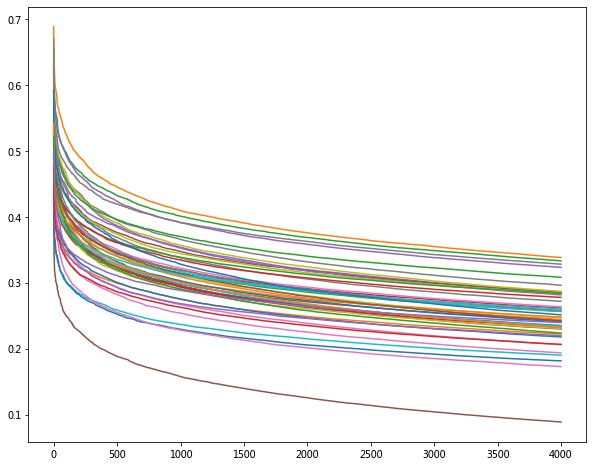

In [196]:
# graph the similarity score

plt.figure(figsize=(10,8))
ax=plt.gca()
for value in simi_econ.values():
    ax.plot(value)
for value in simi_poli.values():
    ax.plot(value)

In [198]:
# sample check

for title in title_filter:
    if "经济体制" in title:
        print (title)

1984-10-27放权 联合 增强企业活力——常州市经济体制改革迈出新步伐
1985-03-31人大代表、武汉市长吴官正认为 城市经济体制改革要说“北京话”
1986-03-11首次全国城市经济体制改革工作会议部署今年任务 贯彻巩固消化补充改善方针推进城市改革 加强和改善宏观控制，发展横向经济联系，为明年改革迈出重要一步作好准备
1987-12-19赵紫阳谈明年经济体制改革任务 重点是完善和发展企业经营机制，搞活企业，多出效益、商品、人才、经验。外贸将层层推行包干制
1984-05-21《城市经济体制改革试点工作座谈会纪要》提出当前改革重点 简政放权搞活企业和流通 沙市常州重庆试点初获成效，有条件的省、区可选定中等城市试点
1993-12-05江泽民在全国经济工作会议闭幕时发表重要讲话强调抓住机遇加快改革开放和现代化建设步伐本世纪末初步建立社会主义市场经济体制李鹏主持会议 乔石朱镕基刘华清胡锦涛等出席
1993-01-29加快教育改革适应社会主义市场经济体制中国人民大学大幅调整学科
1993-11-17中共中央关于建立社会主义市场经济体制若干问题的决定（中国共产党第十四届中央委员会第三次全体会议１９９３年１１月１４日通过）
1999-05-31江泽民在武汉主持召开六省区国有企业改革和发展座谈会强调 朝着建立社会主义市场经济体制的目标 在深化改革中探索国有企业发展新路子
1984-10-21中共中央关于经济体制改革的决定 （中国共产党第十二届中央委员会第三次全体会议一九八四年十月二十日通过）
1984-11-16全国人大常委会委员连日举行学习、讨论、研究座谈会 领会经济体制改革决定的基本精神
1984-12-15关于在经济体制改革中充分发挥共青团作用的决定 （中国共产主义青年团第十一届中央委员会第三次全体会议一九八四年十二月十四日通过）
1982-05-07经济体制改革的重要尝试
1986-03-17赵紫阳听取全国城市经济体制改革工作会议情况汇报后强调 发展横向经济联合可以出效益促改革
1998-12-01划时代的体制创新——建立社会主义市场经济体制
1989-02-05贺光辉谈经济体制改革的形势和任务 整顿治理不意味着改革“停滞”“倒退”
1992-06-24国家体改委主任陈锦华在全国政协常委会上提出企业改革是整个经济体制改革中心环节
1993-01-12李鹏在全

In [200]:
%%time

# get corpus final

corpus_final=sample_all2[:0]

for title in title_filter:
    corpus_final=corpus_final.append(sample_all2[sample_all2['date_title']==title])

CPU times: user 4min 39s, sys: 6.82 s, total: 4min 46s
Wall time: 4min 54s


In [204]:
len(corpus_final)==len(title_filter)

True

In [203]:
corpus_final['date_title'].value_counts()

1989-03-01著名国际问题专家宦乡逝世                                         1
1987-12-31我国民兵在调整改革中发展                                         1
1987-10-17改革应怎样深化？ 本报邀请部分省市的同志座谈纪要（下）                          1
1984-03-17加强责任制 扩大自主权——交大管理改革见闻之六                              1
1998-04-13建设一支高素质的干部队伍——学习江泽民同志关于干部队伍建设的论述                     1
                                                              ..
1981-09-17杭州职业中学的“危机”                                          1
1983-04-15新机构要有新气象                                             1
1979-12-22围绕解决经济问题深入讨论真理标准 甘肃省开展真理标准讨论补课，端正思想路线，落实经济政策，初见成效    1
1999-05-19朱镕基在全国粮食流通体制改革工作会议上强调 继续深化粮食流通体制改革 着力促进粮食种植结构调整      1
1985-11-24跳出就财政论财政的圈子                                          1
Name: date_title, Length: 9691, dtype: int64

In [208]:
corpus_final_sort=corpus_final.sort_values(['date','issue'])

In [209]:
corpus_final_sort

,year,month,date,issue,column,date_title,title,author,text,tokenized_sent,token_para
64375,1965,1,1965-01-03,2,NaN,1965-01-03坚决破除迷信 改进原有设计,坚决破除迷信 改进原有设计,NaN,坚决破除迷信 改进原有设计洛阳轴承厂在严格的科学精神指导下，开展群众性的技术革新活动，轴承品...,"[[坚决, 破除迷信, 改进, 原有, 设计], [洛阳, 轴承厂, 严格, 科学, 精神,...","[坚决 破除迷信 改进 原有 设计, 洛阳 轴承厂 严格 科学 精神 指导 开展 群众性 技..."
64388,1965,1,1965-01-03,3,NaN,1965-01-03用新的斗争和新的成就迎接新的一年,用新的斗争和新的成就迎接新的一年,NaN,用新的斗争和新的成就迎接新的一年金日成首相号召朝鲜人民努力完成七年计划和加强反修斗争艾地主席...,"[[斗争, 成就, 迎接, 一年, 金日成, 首相, 号召, 朝鲜, 人民, 努力完成, 七...",[斗争 成就 迎接 一年 金日成 首相 号召 朝鲜 人民 努力完成 七年 计划 加强 反修 ...
64446,1965,1,1965-01-05,2,社论,1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会...,革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就,NaN,革命的大会 民主的大会 团结的大会第三届全国人民代表大会第一次会议胜利闭幕了。会议听取了周恩...,"[[革命, 大会, 民主, 大会, 团结, 大会], [第三届, 全国人民代表大会, 第一次...","[革命 大会 民主 大会 团结 大会, 第三届 全国人民代表大会 第一次 会议 胜利 闭幕,..."
64573,1965,1,1965-01-08,4,NaN,1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运,美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运,NaN,朝越坦等国舆论抨击约翰逊国情咨文以和平词藻掩饰侵略野心美帝陷入各国人民四面八方包围之中 约...,"[[朝越, 坦等国, 舆论, 抨击, 约翰逊, 国情咨文, 和平, 词藻, 掩饰, 侵略, ...","[朝越 坦等国 舆论 抨击 约翰逊 国情咨文 和平 词藻 掩饰 侵略 野心, 美帝 陷入 各..."
64584,1965,1,1965-01-09,2,短评,1965-01-09创造力的解放,创造力的解放,NaN,卢王庄公社第一年种水稻，就得到了好收成。这件事情又一次雄辩地说明：社会主义革命是社会主义生产...,"[[卢王庄, 公社, 第一年, 水稻, 得到, 好收成], [这件, 事情, 一次, 雄辩,...","[卢王庄 公社 第一年 水稻 得到 好收成, 这件 事情 一次 雄辩 说明 社会主义 革命 ..."
...,...,...,...,...,...,...,...,...,...,...,...
560917,2002,12,2002-12-18,1_要闻,NaN,2002-12-18李鹏在福建考察时指出人大要为发展民主政治建设政治文明作贡献,李鹏在福建考察时指出人大要为发展民主政治建设政治文明作贡献,傅旭蔡小伟,本报福州12月17日电记者傅旭、蔡小伟报道：全国人大常委会委员长李鹏近日在福建就全国人大常委...,"[[本报, 福州, 12, 17, 日电, 记者, 傅旭, 蔡小伟, 报道, 全国人大常委会...",[本报 福州 12 17 日电 记者 傅旭 蔡小伟 报道 全国人大常委会 委员长 李鹏 近日...
560968,2002,12,2002-12-19,2_要闻,NaN,2002-12-19社区深处党旗红——福州市鼓楼区社区党建工作调查,社区深处党旗红——福州市鼓楼区社区党建工作调查,蔡小伟赵鹏,今年50多岁的老党员刘用镇，4年前从外地搬到福州市鼓楼区福屿社区开了一家饮食店。生意红火，收...,"[[今年, 50, 多岁, 党员, 刘用, 年前, 外地, 福州市, 鼓楼区, 福屿, 社区...","[今年 50 多岁 党员 刘用 年前 外地 福州市 鼓楼区 福屿 社区 一家 饮食店, 生意..."
561196,2002,12,2002-12-24,1_要闻,NaN,2002-12-24人大常委会第三十一次会议举行 李鹏主持全体会议并参加分组审议,人大常委会第三十一次会议举行 李鹏主持全体会议并参加分组审议,傅旭石国胜,本报北京12月23日讯记者傅旭、石国胜报道：九届全国人大常委会第三十一次会议今天上午举行全体...,"[[本报, 北京, 12, 23, 日讯, 记者, 傅旭, 石国胜, 报道, 九届全国人大常...",[本报 北京 12 23 日讯 记者 傅旭 石国胜 报道 九届全国人大常委会 第三十一次 会...
561277,2002,12,2002-12-26,1_要闻,NaN,2002-12-26外出闯世界找到致富路长春：劳务输出成为农民增收增长点,外出闯世界找到致富路长春：劳务输出成为农民增收增长点,李忠春江山,本报长春12月25日电记者李忠春、江山报道：吉林省长春市把农民增收作为农村工作的主要目标，引...,"[[本报, 长春, 12, 25, 日电, 记者, 李忠春, 江山, 报道, 吉林省, 长春...",[本报 长春 12 25 日电 记者 李忠春 江山 报道 吉林省 长春市 农民 增收 作为 ...


### time distribution check

In [223]:
# time distribution

year_dict_final={}
year_dict_raw={}

for year in range(1965,2003):
    year_dict_final[str(year)]=len(corpus_final_sort[corpus_final_sort['year']==year])/len(corpus_final_sort)
    year_dict_raw[str(year)]=len(sample_all2[sample_all2['year']==year])/len(sample_all2)

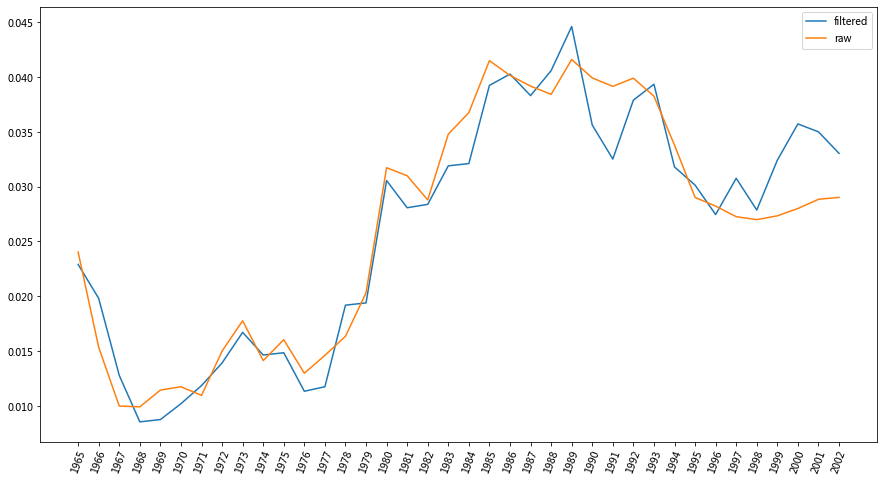

In [228]:
# plot time dist

plt.figure(figsize=(15,8))
ax=plt.gca()
ax.plot(list(year_dict_final.keys()),list(year_dict_final.values()),label='filtered')
ax.plot(list(year_dict_raw.keys()),list(year_dict_raw.values()),label='raw')
plt.xticks(rotation=70)
ax.legend()

In [231]:
sum(list(year_dict_final.values()))

0.9999999999999998

In [232]:
sum(list(year_dict_raw.values()))

1.0000000000000002

## output final corpus and sample loading methods

In [233]:
# option 1

len(corpus_final_sort)

9691

In [234]:
corpus_final_sort.to_csv('final_corpus_rmrb.csv')

# see "load corpus" section at the beginning to load corpus (particularly for string2list)-shown below
# csv available on BOX

In [235]:
# sample loading

sample_loading_df=pd.read_csv('final_corpus_rmrb.csv')

In [236]:
sample_loading_df.head()

,Unnamed: 0,year,month,date,issue,column,date_title,title,author,text,tokenized_sent,token_para
0,64375,1965,1,1965-01-03,2,NaN,1965-01-03坚决破除迷信 改进原有设计,坚决破除迷信 改进原有设计,NaN,坚决破除迷信 改进原有设计洛阳轴承厂在严格的科学精神指导下，开展群众性的技术革新活动，轴承品...,"[['坚决', '破除迷信', '改进', '原有', '设计'], ['洛阳', '轴承厂...","['坚决 破除迷信 改进 原有 设计', '洛阳 轴承厂 严格 科学 精神 指导 开展 群众..."
1,64388,1965,1,1965-01-03,3,NaN,1965-01-03用新的斗争和新的成就迎接新的一年,用新的斗争和新的成就迎接新的一年,NaN,用新的斗争和新的成就迎接新的一年金日成首相号召朝鲜人民努力完成七年计划和加强反修斗争艾地主席...,"[['斗争', '成就', '迎接', '一年', '金日成', '首相', '号召', '...",['斗争 成就 迎接 一年 金日成 首相 号召 朝鲜 人民 努力完成 七年 计划 加强 反修...
2,64446,1965,1,1965-01-05,2,社论,1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会...,革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就,NaN,革命的大会 民主的大会 团结的大会第三届全国人民代表大会第一次会议胜利闭幕了。会议听取了周恩...,"[['革命', '大会', '民主', '大会', '团结', '大会'], ['第三届',...","['革命 大会 民主 大会 团结 大会', '第三届 全国人民代表大会 第一次 会议 胜利 ..."
3,64573,1965,1,1965-01-08,4,NaN,1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运,美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运,NaN,朝越坦等国舆论抨击约翰逊国情咨文以和平词藻掩饰侵略野心美帝陷入各国人民四面八方包围之中 约...,"[['朝越', '坦等国', '舆论', '抨击', '约翰逊', '国情咨文', '和平'...","['朝越 坦等国 舆论 抨击 约翰逊 国情咨文 和平 词藻 掩饰 侵略 野心', '美帝 陷..."
4,64584,1965,1,1965-01-09,2,短评,1965-01-09创造力的解放,创造力的解放,NaN,卢王庄公社第一年种水稻，就得到了好收成。这件事情又一次雄辩地说明：社会主义革命是社会主义生产...,"[['卢王庄', '公社', '第一年', '水稻', '得到', '好收成'], ['这件...","['卢王庄 公社 第一年 水稻 得到 好收成', '这件 事情 一次 雄辩 说明 社会主义 ..."


In [237]:
sample_loading_df=sample_loading_df.drop(['Unnamed: 0'], axis=1)

In [239]:
# transfer string back to list

tokenized_sent_str2=sample_loading_df['tokenized_sent'].values

In [240]:
token_sent_clean2=[]
for doc in tokenized_sent_str2:
    #print(doc)
    token_sent_clean2.append([[y.strip().strip(string.punctuation) for y in x.split(',') if len(y)>0] 
                             for x in doc.lstrip('[').rstrip(']').split(']') if len(x)>0])

In [241]:
sample_loading_df=sample_loading_df.drop(['tokenized_sent'],axis=1)
sample_loading_df.insert(10,'tokenized_sent',token_sent_clean2,True)

In [242]:
tokenized_para_str2=sample_loading_df['token_para'].values

In [243]:
token_para_clean2=[]
for doc in tokenized_para_str2:
    #print(doc)
    token_para_clean2.append([x.strip().strip("'") 
                             for x in doc.lstrip('[').rstrip(']').split(',') if len(x)>0])

In [244]:
sample_loading_df=sample_loading_df.drop(['token_para'],axis=1)
sample_loading_df.insert(9, 'token_para',token_para_clean2,True)

In [248]:
sample_loading_df[:1]['token_para'][0][:10]

['坚决 破除迷信 改进 原有 设计',
 '洛阳 轴承厂 严格 科学 精神 指导 开展 群众性 技术革新 活动 轴承 品种 较原 设计 增加三倍 以上 产品 精度 普遍 前年 提高 一级 光洁度 提高 一大',
 '新华社 郑州 二日 洛阳 轴承厂 破除 对原 设计 迷信 发动 职工群众 技术革新 增加 品种 提高质量',
 '目前 这个 生产 轴承 品种 较原 设计 增加三倍 以上',
 '按照 原来 设计 这个 只能 生产 大型 轴承 现在 生产 一百多种 冶金 石油 工业用 特大型 轴承',
 '设计 这个 最好 产品 精密 轴承 现在 生产 很多 精密 轴承 耐高温 耐腐蚀 特殊 性能 轴承',
 '去年 这个 产品 精度 普遍 前年 提高 一级 光洁度 提高 一大',
 '洛阳 轴承厂 国外 设计 现代化 大型 工厂',
 '反映 过去 有些 思想 懒惰 认为 这样 工厂 技术 先进 机械化 自动化 程度 只要 按照 设计 要求 掌握 技术 进行 生产 不错 技术革新 反而 可能 搞坏',
 '但是 近几年来 这个 领导 职工群众 生产实践 感到 这个 确有 许多 需要 改进 地方 于是 领导 决定 严格 科学 精神 指导 开展 技术革新 活动']

In [254]:
sample_loading_df[:1]['tokenized_sent'][0][:2]

[['坚决', '破除迷信', '改进', '原有', '设计'],
 ['洛阳',
  '轴承厂',
  '严格',
  '科学',
  '精神',
  '指导',
  '开展',
  '群众性',
  '技术革新',
  '活动',
  '轴承',
  '品种',
  '较原',
  '设计',
  '增加三倍',
  '以上',
  '产品',
  '精度',
  '普遍',
  '前年',
  '提高',
  '一级',
  '光洁度',
  '提高',
  '一大']]

In [263]:
# option 2

# it requires adding the date_title col to ensure uniqueness of title (see "adding date_title" above)

len(corpus_final_sort['date_title'].values)

9691

In [267]:
with open("output_datetitle_filtered.txt", "w") as text_file:
    for title in corpus_final_sort['date_title'].values:
        text_file.write(title+'\n')

In [271]:
# sample loading

# it requires the pre_loading of the whole corpus

sample_loading_titles=[]

with open("output_datetitle_filtered.txt", "r") as text_file:
    for line in text_file:
        sample_loading_titles.append(line[:-1]) # rm \n

In [272]:
len(sample_loading_titles)

9691

In [273]:
sample_loading_titles[:10]

['1965-01-03坚决破除迷信 改进原有设计',
 '1965-01-03用新的斗争和新的成就迎接新的一年',
 '1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就',
 '1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运',
 '1965-01-09创造力的解放',
 '1965-01-09艾地主席号召印度尼西亚人民完成两项民族任务 粉碎美帝文化侵略 打倒官僚资本家 强调必须确立以纳沙贡为核心的革命民族团结',
 '1965-01-09西哈努克亲王说柬埔寨拒绝美援后比以前更健康 柬埔寨抗美勇气为别国树立了榜样',
 '1965-01-09经济实力的消长改变了帝国主义阵营内部力量的均势 美国同西欧之间经济矛盾进一步激化',
 '1965-01-09各国公众和舆论要求巴西当局释放中国人员 对中国人员的审判是对新兴力量犯下罪行 世界进步人民高举正义旗帜反对美帝阴谋',
 '1965-01-14法国决定抛售美元使美国十分恼火 美国财政部发表声明企图安定人心遏止黄金风潮 法报指出法手中握有王牌随时可以用来对付美国']

In [278]:
%%time

sample_loading_titles_df=sample_all2[:0] # sample_all2 as raw corpus

for datetitle in sample_loading_titles:
    sample_loading_titles_df=sample_loading_titles_df.append(sample_all2[sample_all2['date_title']==datetitle])

CPU times: user 4min 3s, sys: 374 ms, total: 4min 3s
Wall time: 4min 4s


In [279]:
len(sample_loading_titles_df)

9691

In [280]:
sample_loading_titles_df.head()

,year,month,date,issue,column,date_title,title,author,text,tokenized_sent,token_para
64375,1965,1,1965-01-03,2,NaN,1965-01-03坚决破除迷信 改进原有设计,坚决破除迷信 改进原有设计,NaN,坚决破除迷信 改进原有设计洛阳轴承厂在严格的科学精神指导下，开展群众性的技术革新活动，轴承品...,"[[坚决, 破除迷信, 改进, 原有, 设计], [洛阳, 轴承厂, 严格, 科学, 精神,...","[坚决 破除迷信 改进 原有 设计, 洛阳 轴承厂 严格 科学 精神 指导 开展 群众性 技..."
64388,1965,1,1965-01-03,3,NaN,1965-01-03用新的斗争和新的成就迎接新的一年,用新的斗争和新的成就迎接新的一年,NaN,用新的斗争和新的成就迎接新的一年金日成首相号召朝鲜人民努力完成七年计划和加强反修斗争艾地主席...,"[[斗争, 成就, 迎接, 一年, 金日成, 首相, 号召, 朝鲜, 人民, 努力完成, 七...",[斗争 成就 迎接 一年 金日成 首相 号召 朝鲜 人民 努力完成 七年 计划 加强 反修 ...
64446,1965,1,1965-01-05,2,社论,1965-01-05革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会...,革命的大会 民主的大会 团结的大会——庆祝第三届全国人民代表大会第一次会议的伟大成就,NaN,革命的大会 民主的大会 团结的大会第三届全国人民代表大会第一次会议胜利闭幕了。会议听取了周恩...,"[[革命, 大会, 民主, 大会, 团结, 大会], [第三届, 全国人民代表大会, 第一次...","[革命 大会 民主 大会 团结 大会, 第三届 全国人民代表大会 第一次 会议 胜利 闭幕,..."
64573,1965,1,1965-01-08,4,NaN,1965-01-08美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运,美帝陷入各国人民四面八方包围之中 约翰逊反革命两手挽救不了失败命运,NaN,朝越坦等国舆论抨击约翰逊国情咨文以和平词藻掩饰侵略野心美帝陷入各国人民四面八方包围之中 约...,"[[朝越, 坦等国, 舆论, 抨击, 约翰逊, 国情咨文, 和平, 词藻, 掩饰, 侵略, ...","[朝越 坦等国 舆论 抨击 约翰逊 国情咨文 和平 词藻 掩饰 侵略 野心, 美帝 陷入 各..."
64584,1965,1,1965-01-09,2,短评,1965-01-09创造力的解放,创造力的解放,NaN,卢王庄公社第一年种水稻，就得到了好收成。这件事情又一次雄辩地说明：社会主义革命是社会主义生产...,"[[卢王庄, 公社, 第一年, 水稻, 得到, 好收成], [这件, 事情, 一次, 雄辩,...","[卢王庄 公社 第一年 水稻 得到 好收成, 这件 事情 一次 雄辩 说明 社会主义 革命 ..."


In [4]:
%%time

# sample loading models

sample_d2v = gensim.models.word2vec.Word2Vec.load('rmD2V')

CPU times: user 1.91 s, sys: 415 ms, total: 2.33 s
Wall time: 2.33 s


In [5]:
sample_d2v.docvecs[19]

array([ 0.1390343 , -0.04184093,  0.20951532,  0.08464912, -0.02633805,
       -0.3240081 , -0.08124724, -0.18342079,  0.18068203,  0.01235944,
        0.21951292,  0.04588672,  0.4114881 , -0.38541275,  0.4054298 ,
       -0.1226418 , -0.00150532,  0.0074193 ,  0.12879644,  0.29127347,
       -0.09779221, -0.1276845 ,  0.15429698,  0.3276099 ,  0.07633323,
       -0.11210741,  0.08943482, -0.15572542, -0.14702825,  0.05651556,
        0.15699483, -0.20961007,  0.02354704,  0.24540584, -0.19799396,
        0.10389581,  0.12611862,  0.13575055,  0.2294488 ,  0.07824612,
       -0.15885654,  0.07462155,  0.13403511,  0.24623802, -0.21551512,
        0.10353684,  0.11034467,  0.04615293, -0.09779307,  0.04260863,
        0.13664238,  0.13452247,  0.05553785, -0.3185732 ,  0.0717543 ,
        0.23060913, -0.42409918, -0.13239972, -0.17354128,  0.00685339,
        0.11220478, -0.07598538,  0.00786897, -0.09047474, -0.10854724,
       -0.08250108,  0.160467  ,  0.25674373, -0.05683688, -0.10

In [7]:
sample_d2v['经济']

array([-0.2886183 ,  0.82047886,  1.5868014 ,  0.9601841 ,  0.68216187,
        1.3617811 ,  3.1735983 , -0.8263085 ,  0.27197364,  1.0266342 ,
       -0.3462706 , -0.9655181 , -2.8298173 ,  0.90870476,  0.99788415,
       -1.1183252 ,  1.8899156 ,  0.92084295,  0.9723655 , -2.9304955 ,
        1.7666119 ,  0.47797465, -0.6381282 ,  0.7529383 , -1.295348  ,
       -4.1088753 ,  0.61286974,  0.7788254 , -1.8349595 , -0.6028864 ,
        0.07394097,  0.94317484, -0.5407687 ,  0.16959631, -1.5808766 ,
        1.1400219 , -0.0648832 , -2.1679869 , -0.3616697 , -0.7454695 ,
        0.4145047 , -0.14465374,  0.9014171 ,  3.1625247 , -3.0370965 ,
       -0.5514436 , -0.51505303,  1.9184579 , -3.2404754 , -2.29703   ,
       -0.04783804,  0.35031527,  2.8489053 ,  1.7328421 , -1.284171  ,
        0.9532832 , -1.3551726 , -0.09934222,  0.07061705,  1.6481503 ,
        0.4637063 ,  2.4076352 , -0.6880851 , -0.9293533 , -3.218049  ,
        2.6491942 ,  1.3527428 ,  2.0499802 ,  1.4535805 ,  3.07